# WGAN Camel Training

In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from models.GAN import build_generator, build_critic

# download your full_numpy_bitmap_camel.npy from below. unfortunately it requires license agreement so I can't automate for you
# https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1

camel_file = 'data/camel/full_numpy_bitmap_camel.npy'
X = t.from_numpy(np.load(camel_file)[:25000]).float()
X = X.view(25000, 1, 28, 28) / 255

bs = 64
z_dim = 100

generator = build_generator(gen_init_size=(64, 7, 7), gen_upsample_flags=[True, True, False, False],
                            gen_c=[128, 64, 64, 1],gen_ks=[5, 5, 5, 5], gen_strides=[1, 1, 1, 1],
                            gen_pads=[2, 2, 2, 2], z_dim=z_dim)

critic = build_critic(X[0][None], critic_c=[1, 64, 64, 128, 128], critic_ks=[5, 5, 5, 5],
                      critic_strides=[2, 2, 2, 1], critic_pads=[2, 2, 2, 2], wgan=True)

g_opt = t.optim.RMSprop(generator.parameters(), lr=.00005)
c_opt = t.optim.RMSprop(critic.parameters(), lr=.00005)
device = t.device('cuda') if t.cuda.is_available() else 'cpu'
generator.cuda(device)
critic.cuda(device)

train_loader = DataLoader(TensorDataset(X, X), batch_size=bs, shuffle=True, drop_last=True)


In [2]:
imgs_at_epochs = {50: [], 100: [], 150: [], 200: [], 250: [], 300: []}

for epoch in tqdm(range(1, 301)):
    for i, (imgs, _) in enumerate(train_loader):
        # train critic
        real_imgs = imgs.to(device)
        randn = t.randn(bs, z_dim)
        gen_imgs = generator(randn.to(device))

        c_opt.zero_grad()
        ri_pred = critic(real_imgs)
        gi_pred = critic(gen_imgs)
        c_loss = (-t.mean(ri_pred) + t.mean(gi_pred)) / 2
        c_loss.backward()
        c_opt.step()

        # clip discriminator weights
        for p in critic.parameters():
            p.data.clamp_(-.01, .01)

        # train generator
        if i % 5 == 0:
            gen_imgs = generator(randn.to(device))
            g_opt.zero_grad()
            gi_critic_pred = critic(gen_imgs)
            g_loss = -t.mean(gi_critic_pred)
            g_loss.backward()
            g_opt.step()

    if epoch in imgs_at_epochs:
        imgs_at_epochs[epoch].extend(generator(t.randn(10, z_dim).to(device)))


100%|██████████| 300/300 [4:57:12<00:00, 59.50s/it]  


In [3]:
t.save(generator.state_dict(), 'models/state_dicts/04_02_camel_gen.pth')
t.save(critic.state_dict(), 'models/state_dicts/04_02_camel_critic.pth')

In [4]:
def plot_imgs(imgs):
    row, col = 3, 3,
    f, axarr = plt.subplots(row, col, figsize=(10, 10))
    i = 0
    for r in range(row):
        for c in range(col):
            axarr[r, c].imshow(imgs[i].detach().cpu().squeeze())
            i += 1

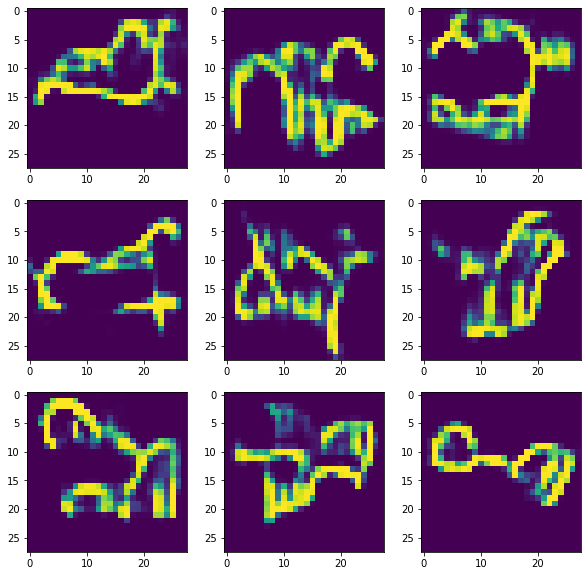

In [5]:
plot_imgs(imgs_at_epochs[50])

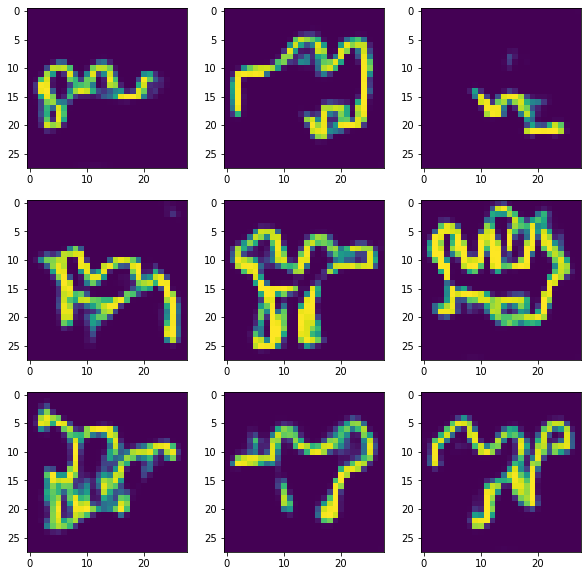

In [6]:
plot_imgs(imgs_at_epochs[100])

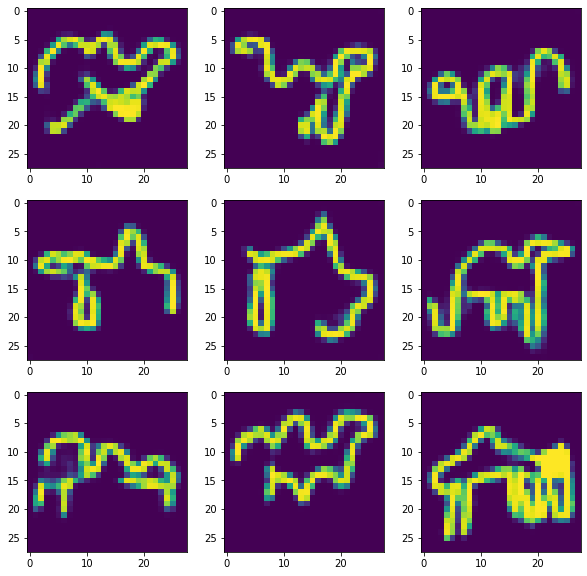

In [7]:
plot_imgs(imgs_at_epochs[200])

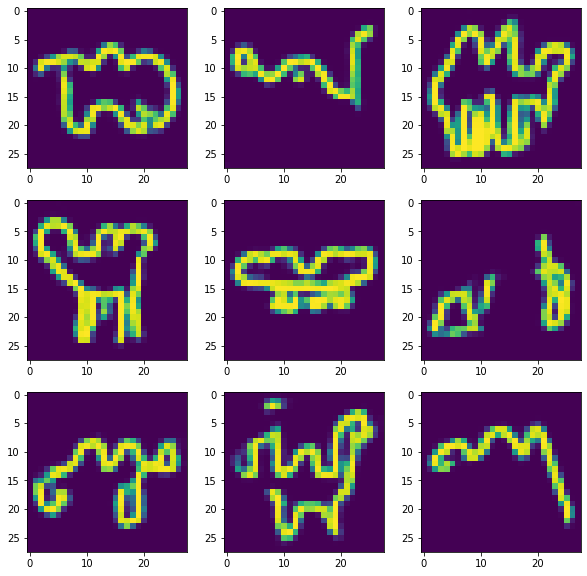

In [8]:
plot_imgs(imgs_at_epochs[300])